Trial 5 Complete [00h 03m 44s]
val_loss: 0.015470603791375956

Best val_loss So Far: 0.015470603791375956
Total elapsed time: 00h 17m 50s
Epoch 1/50
14/14 [==============================] - 7s 177ms/step - loss: 0.0014 - val_loss: 0.0143
Epoch 2/50
14/14 [==============================] - 2s 121ms/step - loss: 0.0014 - val_loss: 0.0194
Epoch 3/50
14/14 [==============================] - 2s 111ms/step - loss: 0.0017 - val_loss: 0.0147
Epoch 4/50
14/14 [==============================] - 2s 112ms/step - loss: 0.0015 - val_loss: 0.0187
Epoch 5/50
14/14 [==============================] - 2s 137ms/step - loss: 0.0014 - val_loss: 0.0154
Epoch 6/50
14/14 [==============================] - 2s 172ms/step - loss: 0.0012 - val_loss: 0.0163
Epoch 7/50
14/14 [==============================] - 2s 130ms/step - loss: 0.0012 - val_loss: 0.0163
Epoch 8/50
14/14 [==============================] - 2s 111ms/step - loss: 0.0012 - val_loss: 0.0156
Epoch 9/50
14/14 [==============================] - 2s 112ms/s

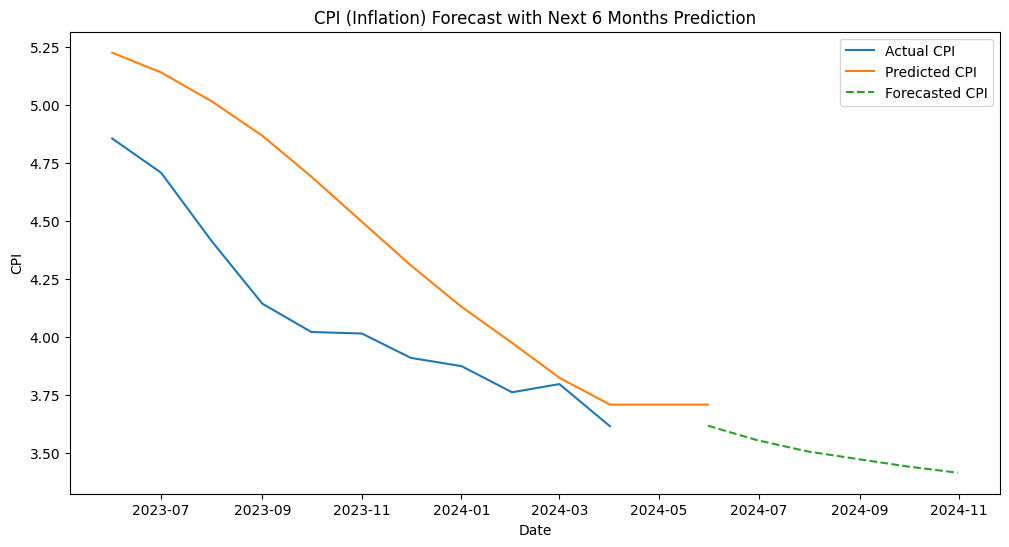

                CPI  Predicted CPI  Forecasted CPI
2023-06-01  4.85522       5.224783             NaN
2023-07-01  4.70760       5.139961             NaN
2023-08-01  4.41280       5.015475             NaN
2023-09-01  4.14370       4.867083             NaN
2023-10-01  4.02170       4.691144             NaN
2023-11-01  4.01509       4.496518             NaN
2023-12-01  3.91012       4.308600             NaN
2024-01-01  3.87468       4.130426             NaN
2024-02-01  3.76195       3.975148             NaN
2024-03-01  3.79729       3.824432             NaN
2024-04-01  3.61553       3.708762             NaN
2024-05-31      NaN       3.708762             NaN
2024-05-31      NaN            NaN        3.617993
2024-06-30      NaN            NaN        3.555869
2024-07-31      NaN            NaN        3.507196
2024-08-31      NaN            NaN        3.474117
2024-09-30      NaN            NaN        3.442555
2024-10-31      NaN            NaN        3.415411


In [60]:
# Step 1: Install the necessary libraries
!pip install keras-tuner

# Step 2: Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import kerastuner as kt

# Load the data
file_path = '3Data.xls'  # Update this if your file path is different
data = pd.read_excel(file_path)

# Inspect the data
print(data.head())
print(data.columns)

# Check for the date column and set it as index if it exists
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
else:
    raise ValueError("No 'Date' column found. Please provide a correct dataset with a 'Date' column.")

# Subset the data to include 'CPI', 'GSCPI', and 'UNRATE'
data = data[['CPI', 'GSCPI', 'UNRATE']]

# Split the data into training and test sets (last 12 values)
df_train = data[:-12]
df_test = data[-12:]

# Normalize the data
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

# Prepare the data for the LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12

X_train, y_train = create_dataset(df_train_scaled, df_train_scaled[:, 0], TIME_STEPS)

# Note: We need to include enough data in the test set to create sequences
extended_test = np.concatenate([df_train_scaled[-TIME_STEPS:], df_test_scaled])
X_test, y_test = create_dataset(extended_test, extended_test[:, 0], TIME_STEPS)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',
                                                                             values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

# Set up the Keras Tuner
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=3,
                        executions_per_trial=3,
                        directory='tuner_dir',
                        project_name='cpi_forecast')

# Run the tuner to find the best model
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, shuffle=False)

# Predict the values
y_pred = best_model.predict(X_test)

# Reverse scaling
y_test_inverse = scaler.inverse_transform(extended_test[TIME_STEPS:])[:, 0]
y_pred_inverse = scaler.inverse_transform(np.concatenate((y_pred, extended_test[TIME_STEPS:, 1:]), axis=1))[:, 0]

# Combine the actual and forecasted values for comparison
combined_df = pd.concat([data, pd.DataFrame(y_pred_inverse, index=df_test.index, columns=['Predicted CPI'])], axis=1)

# Forecast next 6 months (including May and June 2024)
n_future = 6
forecast = []

input_seq = extended_test[-TIME_STEPS:]

for _ in range(n_future):
    input_seq = input_seq.reshape((1, TIME_STEPS, 3))
    pred = best_model.predict(input_seq)
    forecast.append(pred[0])
    # Use zeros for the other features
    new_pred = np.concatenate([pred.reshape((1, 1)), np.zeros((1, 2))], axis=1)
    input_seq = np.append(input_seq[:, 1:, :], new_pred.reshape((1, 1, 3)), axis=1)

forecast = np.array(forecast)
forecast_inverse = scaler.inverse_transform(np.concatenate((forecast, np.zeros((n_future, 2))), axis=1))[:, 0]

# Combine the forecasted values
forecast_dates = pd.date_range(start=df_test.index[-1], periods=n_future + 1, freq='M')[1:]
forecast_df = pd.DataFrame(forecast_inverse, index=forecast_dates, columns=['Forecasted CPI'])

# Ensure a seamless transition by combining the last predicted value with the first forecasted value
combined_df.loc[forecast_dates[0], 'Predicted CPI'] = combined_df['Predicted CPI'].iloc[-1]
combined_df = pd.concat([combined_df, forecast_df])

# Plot the combined results for the last 18 months (12 test + 6 forecast)
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index[-18:], combined_df['CPI'][-18:], label='Actual CPI')
plt.plot(combined_df.index[-18:], combined_df['Predicted CPI'][-18:], label='Predicted CPI')
plt.plot(combined_df.index[-18:], combined_df['Forecasted CPI'][-18:], label='Forecasted CPI', linestyle='--')
plt.legend()
plt.title('CPI (Inflation) Forecast with Next 6 Months Prediction')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

# Display the forecast table
forecast_table = combined_df[['CPI', 'Predicted CPI', 'Forecasted CPI']].tail(18)
print(forecast_table)
